https://keras.io/examples/nlp/pretrained_word_embeddings/

In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt

import gensim
from gensim.models import Word2Vec,KeyedVectors

import logging
import nltk
from nltk.corpus import brown   
import os 

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
nltk.download('brown')

import csv
import transformers
from scipy.spatial.distance import cosine
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
#% matplotlib inline

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
c:\Users\henry\Desktop\MastersProject\QC_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [292]:
# read the words from your WordData.csv file
def GetWords():
    words = []
    with open('DataFiles/WordData.csv', 'r') as f:       
        for line in f:
            if line.strip()=='Word':continue #Skip heading
            words.append(line.strip())
    return words

def GetWordPairs():
	words = []
	with open('DataFiles/PhraseData.csv', 'r') as f:  
		pair1, pair2 = [], []
		for line in f:
			if line.strip()=='Word':continue #Skip heading
			for phrase in f:
				phrase = phrase.split(" ")
				pair1.append([phrase[0], phrase[2]])
				pair1.append([phrase[1], phrase[3]])
		words.append([pair1])
	return words[0][0]

word_pairs = GetWordPairs()
print("First 5 Word Pairs: ")
print(word_pairs[:4])


words = GetWords()
print("\nFirst 5 Words: ")
words[0:5]

First 5 Word Pairs: 
[['development', 'action'], ['plan,', 'programme,'], ['training', 'education'], ['programme,', 'course,']]

First 5 Words: 


['development', 'plan', 'action', 'programme', 'training']

# Word2Vec

## Training

In [213]:
dimensions = [10,20,30,40,50,60,70,80,90] + list(np.arange(100,800,100))

In [216]:
sentences = brown.sents()
for vector_dims in dimensions:
	if not os.path.exists('C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_'+str(vector_dims)):
		model = gensim.models.Word2Vec(sentences, min_count=1,vector_size=vector_dims, window=5, workers=4)
		model.save('C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_'+str(vector_dims))
		print("Made Word2Vec Model of ", str(vector_dims), " dimensions")

2023-01-19 12:15:31,523 : INFO : collecting all words and their counts
2023-01-19 12:15:31,525 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-01-19 12:15:31,885 : INFO : PROGRESS: at sentence #10000, processed 219770 words, keeping 23488 word types
2023-01-19 12:15:32,239 : INFO : PROGRESS: at sentence #20000, processed 430477 words, keeping 34367 word types
2023-01-19 12:15:32,631 : INFO : PROGRESS: at sentence #30000, processed 669056 words, keeping 42365 word types
2023-01-19 12:15:32,971 : INFO : PROGRESS: at sentence #40000, processed 888291 words, keeping 49136 word types
2023-01-19 12:15:33,250 : INFO : PROGRESS: at sentence #50000, processed 1039920 words, keeping 53024 word types
2023-01-19 12:15:33,444 : INFO : collected 56057 word types from a corpus of 1161192 raw words and 57340 sentences
2023-01-19 12:15:33,444 : INFO : Creating a fresh vocabulary
2023-01-19 12:15:33,570 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 reta

Made Word2Vec Model of  10  dimensions


2023-01-19 12:15:44,155 : INFO : PROGRESS: at sentence #10000, processed 219770 words, keeping 23488 word types
2023-01-19 12:15:44,464 : INFO : PROGRESS: at sentence #20000, processed 430477 words, keeping 34367 word types
2023-01-19 12:15:44,794 : INFO : PROGRESS: at sentence #30000, processed 669056 words, keeping 42365 word types
2023-01-19 12:15:45,123 : INFO : PROGRESS: at sentence #40000, processed 888291 words, keeping 49136 word types
2023-01-19 12:15:45,372 : INFO : PROGRESS: at sentence #50000, processed 1039920 words, keeping 53024 word types
2023-01-19 12:15:45,572 : INFO : collected 56057 word types from a corpus of 1161192 raw words and 57340 sentences
2023-01-19 12:15:45,572 : INFO : Creating a fresh vocabulary
2023-01-19 12:15:45,694 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 56057 unique words (100.00% of original 56057, drops 0)', 'datetime': '2023-01-19T12:15:45.694719', 'gensim': '4.3.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, Oct 11

Made Word2Vec Model of  20  dimensions


2023-01-19 12:15:56,283 : INFO : PROGRESS: at sentence #10000, processed 219770 words, keeping 23488 word types
2023-01-19 12:15:56,594 : INFO : PROGRESS: at sentence #20000, processed 430477 words, keeping 34367 word types
2023-01-19 12:15:56,927 : INFO : PROGRESS: at sentence #30000, processed 669056 words, keeping 42365 word types
2023-01-19 12:15:57,254 : INFO : PROGRESS: at sentence #40000, processed 888291 words, keeping 49136 word types
2023-01-19 12:15:57,504 : INFO : PROGRESS: at sentence #50000, processed 1039920 words, keeping 53024 word types
2023-01-19 12:15:57,698 : INFO : collected 56057 word types from a corpus of 1161192 raw words and 57340 sentences
2023-01-19 12:15:57,698 : INFO : Creating a fresh vocabulary
2023-01-19 12:15:57,822 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 56057 unique words (100.00% of original 56057, drops 0)', 'datetime': '2023-01-19T12:15:57.822325', 'gensim': '4.3.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, Oct 11

Made Word2Vec Model of  30  dimensions


2023-01-19 12:16:08,312 : INFO : PROGRESS: at sentence #10000, processed 219770 words, keeping 23488 word types
2023-01-19 12:16:08,622 : INFO : PROGRESS: at sentence #20000, processed 430477 words, keeping 34367 word types
2023-01-19 12:16:08,957 : INFO : PROGRESS: at sentence #30000, processed 669056 words, keeping 42365 word types
2023-01-19 12:16:09,285 : INFO : PROGRESS: at sentence #40000, processed 888291 words, keeping 49136 word types
2023-01-19 12:16:09,532 : INFO : PROGRESS: at sentence #50000, processed 1039920 words, keeping 53024 word types
2023-01-19 12:16:09,726 : INFO : collected 56057 word types from a corpus of 1161192 raw words and 57340 sentences
2023-01-19 12:16:09,726 : INFO : Creating a fresh vocabulary
2023-01-19 12:16:09,852 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 56057 unique words (100.00% of original 56057, drops 0)', 'datetime': '2023-01-19T12:16:09.851166', 'gensim': '4.3.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, Oct 11

Made Word2Vec Model of  40  dimensions


In [217]:
model = Word2Vec.load('C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_'+str(700))
print("First 10 dims of second word in 700 dims: ")
model.wv[words[1]][0:10]

2023-01-19 12:16:20,313 : INFO : loading Word2Vec object from C:\Users\henry\Desktop\MastersProject\QNLP_MasterWork\Word2VecModels\brown_model_700
2023-01-19 12:16:20,332 : INFO : loading wv recursively from C:\Users\henry\Desktop\MastersProject\QNLP_MasterWork\Word2VecModels\brown_model_700.wv.* with mmap=None
2023-01-19 12:16:20,334 : INFO : loading vectors from C:\Users\henry\Desktop\MastersProject\QNLP_MasterWork\Word2VecModels\brown_model_700.wv.vectors.npy with mmap=None
2023-01-19 12:16:20,408 : INFO : loading syn1neg from C:\Users\henry\Desktop\MastersProject\QNLP_MasterWork\Word2VecModels\brown_model_700.syn1neg.npy with mmap=None
2023-01-19 12:16:20,456 : INFO : setting ignored attribute cum_table to None
2023-01-19 12:16:20,758 : INFO : Word2Vec lifecycle event {'fname': 'C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_700', 'datetime': '2023-01-19T12:16:20.758884', 'gensim': '4.3.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, Oct 11 202

First 10 dims of second word in 700 dims: 


array([ 0.04635248,  0.09131659, -0.09650849,  0.2753113 , -0.16141367,
       -0.2004109 ,  0.05806495,  0.23120125,  0.02272628,  0.13151366],
      dtype=float32)

## Testing

Missing Words from the Corpus

In [218]:
model = Word2Vec.load('C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_'+str(700))
print("Missing (removed) Words:")
for word in words:
	try:
		model.wv[word]
	except:
		print(word)
		words.remove(word)

def GetWord2Vec_Vector(model, word):
	 return model.wv[word]

# Make word pairs:
pairs = []
for i in range(int(len(words)/2 +1)):
	pairs.append([words[i], words[i+1]])
	i+=1
print("Example Pairs:")
pairs[0:3]

2023-01-19 12:16:20,795 : INFO : loading Word2Vec object from C:\Users\henry\Desktop\MastersProject\QNLP_MasterWork\Word2VecModels\brown_model_700
2023-01-19 12:16:20,814 : INFO : loading wv recursively from C:\Users\henry\Desktop\MastersProject\QNLP_MasterWork\Word2VecModels\brown_model_700.wv.* with mmap=None
2023-01-19 12:16:20,814 : INFO : loading vectors from C:\Users\henry\Desktop\MastersProject\QNLP_MasterWork\Word2VecModels\brown_model_700.wv.vectors.npy with mmap=None
2023-01-19 12:16:20,874 : INFO : loading syn1neg from C:\Users\henry\Desktop\MastersProject\QNLP_MasterWork\Word2VecModels\brown_model_700.syn1neg.npy with mmap=None
2023-01-19 12:16:20,923 : INFO : setting ignored attribute cum_table to None
2023-01-19 12:16:21,227 : INFO : Word2Vec lifecycle event {'fname': 'C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_700', 'datetime': '2023-01-19T12:16:21.227791', 'gensim': '4.3.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, Oct 11 202

Missing (removed) Words:
Example Pairs:


[['development', 'plan'], ['plan', 'action'], ['action', 'training']]

In [219]:
model_100 = Word2Vec.load('C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_'+str(100))
model_600 = Word2Vec.load('C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_'+str(600))
model_700 = Word2Vec.load('C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_'+str(700))
np.dot(model_100.wv[words[1]],model_100.wv[words[2]]), np.dot(model_600.wv[words[1]],model_600.wv[words[2]]), np.dot(model_700.wv[words[1]],model_700.wv[words[2]])

2023-01-19 12:16:21,280 : INFO : loading Word2Vec object from C:\Users\henry\Desktop\MastersProject\QNLP_MasterWork\Word2VecModels\brown_model_100
2023-01-19 12:16:21,338 : INFO : loading wv recursively from C:\Users\henry\Desktop\MastersProject\QNLP_MasterWork\Word2VecModels\brown_model_100.wv.* with mmap=None
2023-01-19 12:16:21,339 : INFO : setting ignored attribute cum_table to None
2023-01-19 12:16:21,652 : INFO : Word2Vec lifecycle event {'fname': 'C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_100', 'datetime': '2023-01-19T12:16:21.652400', 'gensim': '4.3.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, Oct 11 2022, 16:50:30) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'loaded'}
2023-01-19 12:16:21,668 : INFO : loading Word2Vec object from C:\Users\henry\Desktop\MastersProject\QNLP_MasterWork\Word2VecModels\brown_model_600
2023-01-19 12:16:21,684 : INFO : loading wv recursively from C:\Users\henry\Desktop\M

(20.451641, 20.383715, 20.330574)

In [220]:
dot_prds = []
for dims in dimensions:
	model = Word2Vec.load('C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_'+str(dims))
	dim_dot_prod = []
	for pair in pairs:
		dim_dot_prod.append(np.dot(model.wv[pair[0]],model.wv[pair[1]]))
	dot_prds.append(dim_dot_prod)
dot_prods = np.array(dot_prds)
dot_prods.shape

2023-01-19 12:16:22,675 : INFO : loading Word2Vec object from C:\Users\henry\Desktop\MastersProject\QNLP_MasterWork\Word2VecModels\brown_model_10
2023-01-19 12:16:22,689 : INFO : loading wv recursively from C:\Users\henry\Desktop\MastersProject\QNLP_MasterWork\Word2VecModels\brown_model_10.wv.* with mmap=None
2023-01-19 12:16:22,690 : INFO : setting ignored attribute cum_table to None
2023-01-19 12:16:22,999 : INFO : Word2Vec lifecycle event {'fname': 'C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_10', 'datetime': '2023-01-19T12:16:22.999503', 'gensim': '4.3.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, Oct 11 2022, 16:50:30) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'loaded'}
2023-01-19 12:16:23,022 : INFO : loading Word2Vec object from C:\Users\henry\Desktop\MastersProject\QNLP_MasterWork\Word2VecModels\brown_model_20
2023-01-19 12:16:23,038 : INFO : loading wv recursively from C:\Users\henry\Desktop\Maste

(16, 70)

Text(0, 0.5, 'Percentage Change from current dimension to 700')

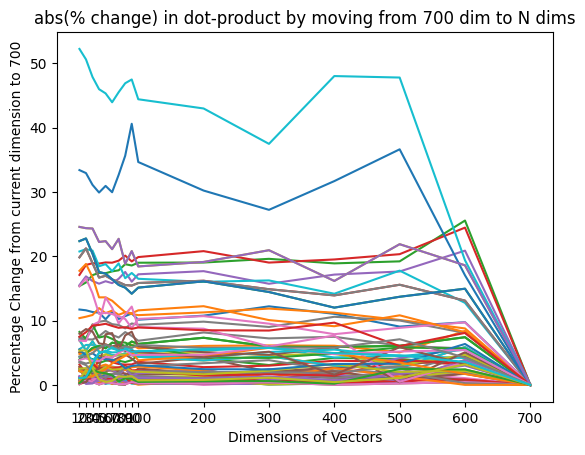

In [221]:
for word_dotprod in dot_prods.T:
	scaled_line = []
	for i, val in reversed(list(enumerate(word_dotprod))):
		try:
			if i == 0:
				scaled_line.append(val - val)
			else:
				scaled_line.append(100*abs((word_dotprod[0] - val)/word_dotprod[i-1]))
		except:
			pass
	plt.plot(dimensions, scaled_line)
plt.title("abs(% change) in dot-product by moving from 700 dim to N dims")
plt.xticks(dimensions)
plt.xlabel("Dimensions of Vectors")
plt.ylabel("Percentage Change from current dimension to 700")

# BERT

In [229]:
class BertEncodingWords():
	#https://colab.research.google.com/drive/1yFphU6PW9Uo6lmDly_ud9a6c4RCYlwdX#scrollTo=Zn0n2S-FWZih
	
	def __init__(self, data):
		# Load pre-trained model tokenizer (vocabulary)
		self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
		self.words = data
		self.model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True).eval()# output_hidden_states is whether the model returns all hidden-states. # Put the model in "evaluation" mode, meaning feed-forward operation. 
		pass
	
	def getWordEmbedding(self, word):
		marked_text = "[CLS] " + word + " [SEP]"
		tokenized_text = self.tokenizer.tokenize(marked_text)	# Tokenize our sentence with the BERT tokenizer.
		return(tokenized_text)	# Print out the tokens.
	
	def preprocessSentence(self, word):
		# Add the special tokens.
		tokenized_text = self.getWordEmbedding(word)
		# Map the token strings to their vocabulary indeces.
		indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)

		# Mark each of the 22 tokens as belonging to sentence "1".
		segments_ids = [1] * len(tokenized_text)

		# Convert inputs to PyTorch tensors
		tokens_tensor = torch.tensor([indexed_tokens])
		segments_tensors = torch.tensor([segments_ids])
		return tokens_tensor, segments_tensors
	
	def hiddenLayersBERT(self, word):
		hidden_states = [] 
		with torch.no_grad():
			outputs = self.model(word[0])
			# https://huggingface.co/transformers/model_doc/bert.html#bertmodel
			hidden_states.append(outputs[2])
		return hidden_states

	def GetEmbeddingsForWord(self, hidden):
		# Stores the token vectors, with shape [22 x 768]
		token_vecs_sum = []

		# `token_embeddings` is a [22 x 12 x 768] tensor.

		# For each token in the sentence...
		for token in hidden:
			# `token` is a [12 x 768] tensor
			# Sum the vectors from the last four layers.
			sum_vec = torch.sum(token[0][0], dim=0)
			
			# Use `sum_vec` to represent `token`.
			token_vecs_sum.append(sum_vec)
		token_embedding_list = token_vecs_sum
		return token_embedding_list
	
	def GetTokenVecSum(self, hidden_state):
		# Stores the token vectors, with shape [22 x 768]
		token_vecs_cum_sum = []

		# `token_embeddings` is a [22 x 12 x 768] tensor.

		# For each token in the sentence...
		for token in hidden_state:

			# `token` is a [12 x 768] tensor
			# Sum the vectors from the last four layers.
			sum_vec = torch.sum(token[0][0], dim=0)
			
			# Use `sum_vec` to represent `token`.
			token_vecs_cum_sum.append(sum_vec)
		token_vecs_sum = token_vecs_cum_sum
		return token_vecs_sum

	def getWordVector(self, word):
		word_to_evaluate = self.preprocessSentence(word)
		hidden = self.hiddenLayersBERT(word_to_evaluate)
		embeddings = self.GetEmbeddingsForWord(hidden)
		return np.array(embeddings[0])

	
	def evaluateWordPair(self, row_numbers):
		sents_to_evaluate = [self.preprocessSentence(self.words[row_numbers[0]]), self.preprocessSentence(self.words[row_numbers[1]])]
		hidden = self.hiddenLayersBERT(sents_to_evaluate)
		embeddings = self.GetEmbeddingsForBothWords(hidden)
		return np.dot(embeddings[1][0], embeddings[1][1])

from scipy.spatial.distance import cosine
def evaluateAllSentPairs():
		res = []
		word_list = getWords()
		for idx, word in enumerate(word_list):
			if idx % 2 == 0:
				try:
					res.append(1 - cosine(bertWwords.getWordVector(word), bertWwords.getWordVector(word_list[idx+1])))
				except:
					continue
			else:
				continue
		return res

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Text(0, 0.5, 'Cosine Similarity')

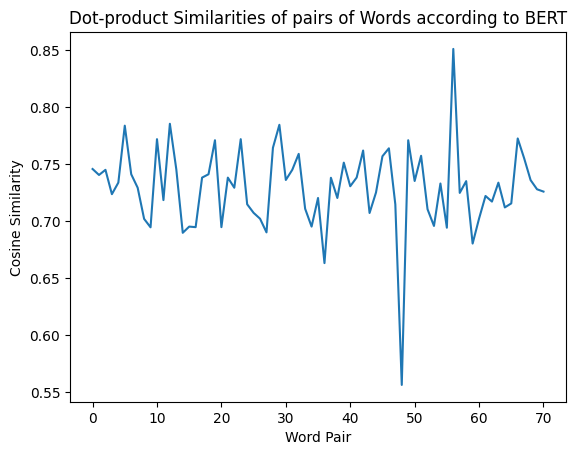

In [232]:
sentences = brown.sents()
bertWwords = BertEncodingWords(getWords())

similarities = evaluateAllSentPairs()
plt.plot(similarities)
plt.title("Dot-product Similarities of pairs of Words according to BERT")
plt.xlabel("Word Pair")
plt.ylabel("Cosine Similarity")

# Comparisons

In [299]:
sentences = brown.sents()
BERT = BertEncodingWords(GetWords())

W2V = Word2Vec.load('C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_'+str(700))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
2023-01-19 14:35:10,771 : INFO : loading Word2Vec object from C:\Users\henry\Desktop\MastersProject\QNLP_MasterWork\Word2VecModels\brown_model_700
2023-01-

In [326]:
BERT_dots = []
W2V_dots = []
for pair in word_pairs:
	#print(pair[0], pair[1])
	try:
		#print(np.dot(BERT.getWordVector(pair[0]), BERT.getWordVector(pair[1])))
		print(pair[0], pair[1],np.dot(GetWord2Vec_Vector(W2V, pair[0]), GetWord2Vec_Vector(W2V, pair[1])))
		BERT_dots.append(np.dot(BERT.getWordVector(pair[0]), BERT.getWordVector(pair[1])))
		W2V_dots.append(np.dot(GetWord2Vec_Vector(W2V, pair[0]), GetWord2Vec_Vector(W2V, pair[1])))
		#print(len(BERT_dots), len(W2V_dots))
	except:
		#BERT_dots.append()
		#W2V_dots.append(0)
		continue

development action 29.081924
training education 15.586242
party government 17.870066
state government 27.319807
tax interest 23.30699
party opposition 7.174312
kitchen bedroom 7.069024
tax family 20.650576
state county 14.540955
state town 23.32088
state county 14.540955
government party 17.870066
market board 15.86261
labour housing 0.64919317
management computer 1.6206692
research training 14.702301
family tax 20.650576
tax wage 13.62237
management planning 11.407053
education service 19.281067
assistant company 5.4537034
intelligence bus 2.753148
television research 8.406947
tax datum 0.18603517
world management 16.360603
company tax 18.981625
league family 5.0880837
personnel management 8.556209
town education 16.642899
future telephone 7.8903794
bedroom education 7.841518
support interest 21.391184
computer state 2.613337
planning football 5.283983
phone state 9.172381


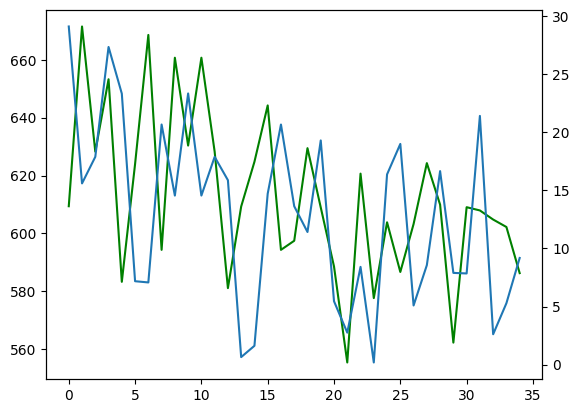

In [327]:
fig, ax = plt.subplots()

ax.plot(BERT_dots, color='g')
ax2 = ax.twinx()
ax2.plot(W2V_dots)

plt.draw()

# Rotations

In [358]:
rotated_words = dict()

for word in words:
	rotated_word_vector = []
	for comaprison_word in words:
		try:
			if word == comaprison_word: 
				continue
			else:
				rotated_word_vector.append(np.dot(GetWord2Vec_Vector(W2V, word), GetWord2Vec_Vector(W2V, comaprison_word)))
		except:
			rotated_word_vector.append(0)
			continue
	rotated_words.update({str(word): np.array(rotated_word_vector)-np.array(rotated_word_vector).mean()})
	

In [359]:
word = 'board'
comaprison_word = 'market'
np.dot(GetWord2Vec_Vector(W2V, word), GetWord2Vec_Vector(W2V, comaprison_word)), np.dot(rotated_words[word], rotated_words[comaprison_word])

(15.86261, 5463.215778196894)

In [353]:
len(rotated_words['board']),len(rotated_words['market']) 

(142, 142)

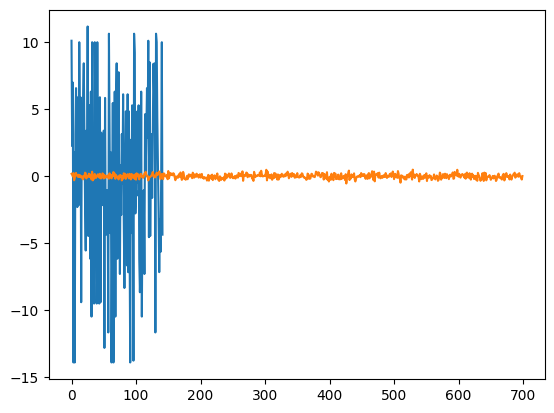

In [364]:
plt.plot(rotated_words[word])
plt.plot(GetWord2Vec_Vector(W2V, word))